In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Предсказывать будем цены, а не доходности.
Так как цены сами по себе предсказывать спроще, они менее похожи на шум, а также подлежат более-менее нормальной декомпозиции. Доходности же можно вычислить, исходя из формулы: $${r_t = \frac{y_t}{y_{t - 1} } - 1}$$

# Загрузка данных

In [2]:
df = pd.read_csv("../Data/American Companies/FORD 1994 2022.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,02.06.1972,2.153220,2.173495,2.141055,2.149165,0.266799,1174468
1,05.06.1972,2.149165,2.169440,2.141055,2.149165,0.266799,5209582
2,06.06.1972,2.149165,2.157275,2.116725,2.124835,0.263778,1424158
3,07.06.1972,2.124835,2.137000,2.112670,2.112670,0.262268,675088
4,08.06.1972,2.112670,2.128890,2.096449,2.096449,0.260255,1038834
...,...,...,...,...,...,...,...
12740,08.12.2022,13.200000,13.260000,13.070000,13.120000,13.120000,32376300
12741,09.12.2022,13.040000,13.360000,13.040000,13.180000,13.180000,41531600
12742,12.12.2022,13.200000,13.470000,13.100000,13.460000,13.460000,35473800
12743,13.12.2022,13.780000,13.920000,13.370000,13.570000,13.570000,57872100


In [3]:
open_price = df.Open
date = df.Date.apply(lambda x: pd.to_datetime(x, dayfirst= True))

In [4]:
bad_data = []
for ind, el in enumerate(open_price):
    try:
        float(el)
        assert(el != "0")
    except:
        print(el)
        bad_data.append(ind)

In [5]:
bad_data = np.array(bad_data)

In [6]:
open_price = open_price.drop(bad_data)
dates = date.drop(bad_data)

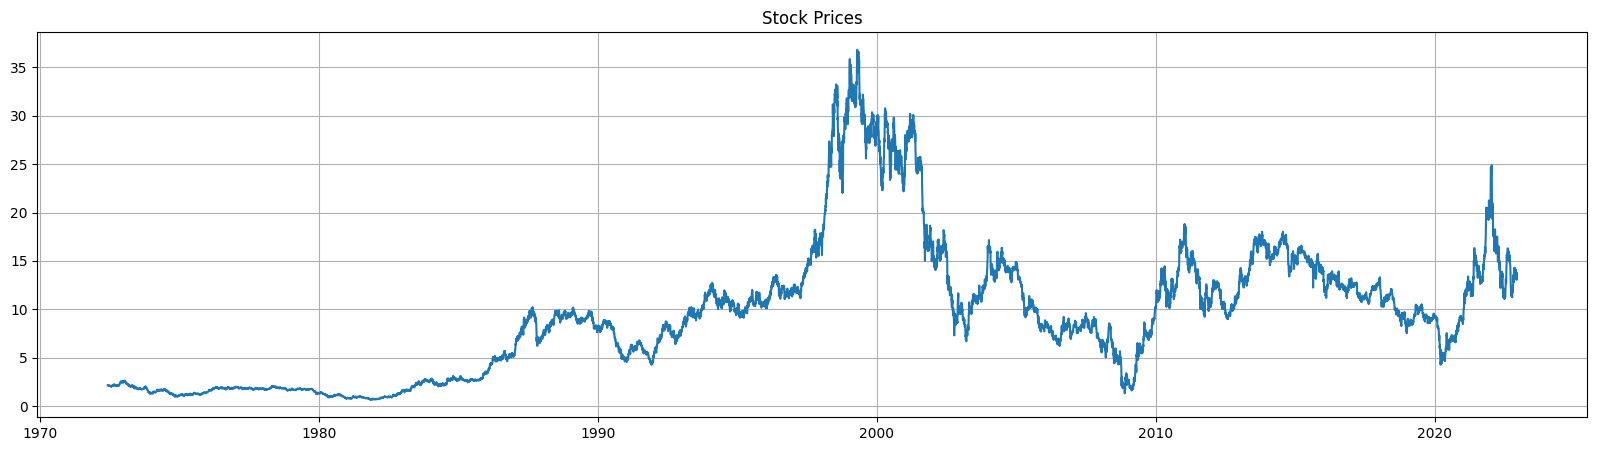

In [7]:
plt.figure(figsize= (20, 5))
plt.title("Stock Prices")
plt.plot(dates[:], open_price[:])
plt.grid(True)
plt.show()

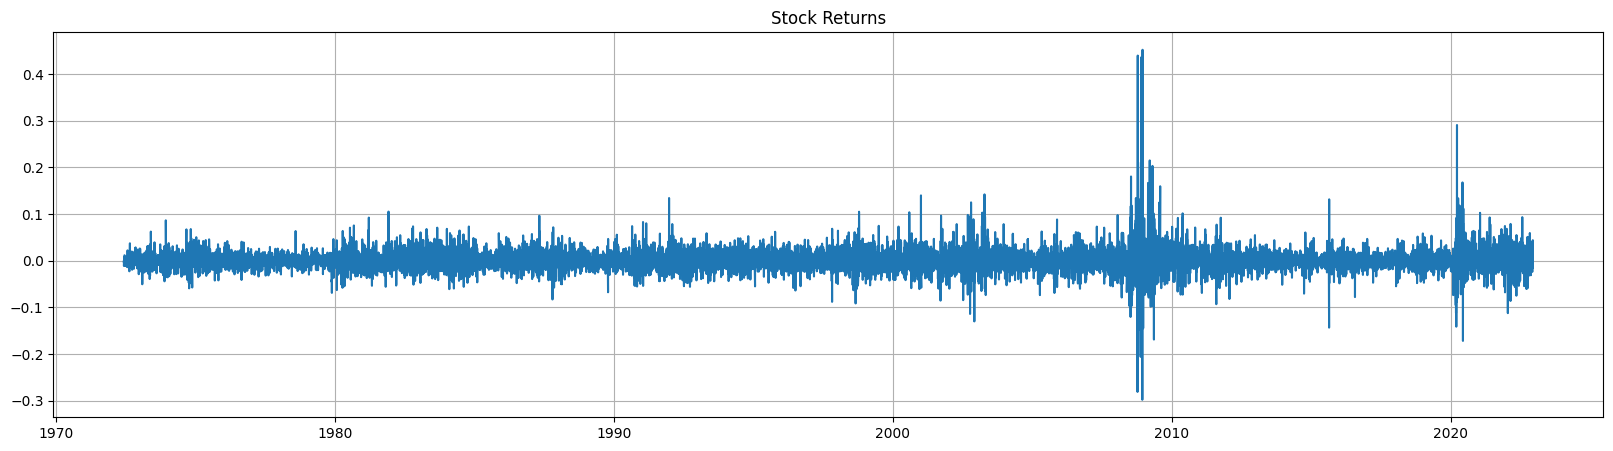

In [8]:
plt.figure(figsize= (20, 5))
plt.title("Stock Returns")
plt.plot(dates[1:], open_price.pct_change()[1:])
plt.grid(True)
plt.show()

In [9]:
open_price = open_price.astype(np.float32).to_numpy()
dates = dates.to_numpy()

# Преобразование данных во входные данные

In [10]:
def data_to_X_y(x, window_size= 40):
    X = []
    y = []
    for i in range(len(x) - window_size):
        row = list(map(lambda a: a, x[i:i + window_size]))
        X.append(np.array(row))
        col = [x[i + window_size]]
        y.append(np.array(col))

    return np.array(X), np.array(y)

# Убираем шум

In [11]:
# from Functions.SSA import SSA

In [12]:
# L = 2
# m_opt, reconstructed_series = SSA.multiple_stage_denoising(open_price, L, max_iter= 500)
# m_opt, reconstructed_series.shape

In [13]:
# start = -100
# end = None
#
# plt.figure(figsize= (20, 5))
# plt.plot(dates[start:end], reconstructed_series[start:end], label= "Reconstructed")
# plt.plot(dates[start:end], open_price[start:end], label= "Initial series", alpha= 0.5)
# plt.grid(True)
# plt.legend(loc= "best")
# plt.show()

### Формирование матрицы траекторий

In [14]:
WINDOW_SIZE = 40 #40
X, y = data_to_X_y(open_price, window_size= WINDOW_SIZE)
dates_x, dates_y = data_to_X_y(dates, window_size= WINDOW_SIZE)

X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

X.shape, X.dtype, y.shape, y.dtype

(torch.Size([12705, 40]), torch.float32, torch.Size([12705, 1]), torch.float32)

# Разбивка на обучение и тест

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_test_x, dates_train_y, dates_test_y = train_test_split(
    dates_x, dates_y,
    test_size= 0.1,
    shuffle= False
)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_val_x, dates_train_y, dates_val_y = train_test_split(
    dates_train_x, dates_train_y,
    test_size= 0.1,
    shuffle= False
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([10290, 40]),
 torch.Size([1144, 40]),
 torch.Size([1271, 40]),
 torch.Size([10290, 1]),
 torch.Size([1144, 1]),
 torch.Size([1271, 1]))

In [17]:
dates_train_x.shape, dates_train_y.shape, dates_val_x.shape, dates_val_y.shape, dates_test_x.shape, dates_test_y.shape

((10290, 40), (10290, 1), (1144, 40), (1144, 1), (1271, 40), (1271, 1))

# Скалирование данных

In [18]:
class MinMaxScaler():
    def __init__(self):
        self.min = 0
        self.max = 1

    def fit(self, data):
        self.min = data.min()
        self.max = data.max()

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform(self, data):
        return (self.max - self.min) * data + self.min

    def __str__(self):
        return f"Min: {self.min}\nMax: {self.max}"


class StandardScaler():
    def __init__(self):
        self.mean = 0
        self.std = 1

    def fit(self, data):
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return self.std * data + self.mean

    def __str__(self):
        return f"Mean: {self.mean}\nStd: {self.std}"


scaler = MinMaxScaler()
scaler.fit(torch.concat((torch.unsqueeze(X_train[0], dim= 1), y_train, y_val), dim=0))

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.transform(y_train)
y_val_scaled = scaler.transform(y_val)
y_test_scaled = scaler.transform(y_test)
print(scaler)

Min: 0.6437360048294067
Max: 36.81948471069336


# Создание датасетов и загрузчиков

In [19]:
class TimeSeriesDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [20]:
train_dataset = TimeSeriesDataSet(X_train_scaled, y_train_scaled)
val_dataset = TimeSeriesDataSet(X_val_scaled, y_val_scaled)
test_dataset = TimeSeriesDataSet(X_test_scaled, y_test_scaled)

# train_dataset = TimeSeriesDataSet(X_train, y_train)
# val_dataset = TimeSeriesDataSet(X_val, y_val)
# test_dataset = TimeSeriesDataSet(X_test, y_test)

In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= 512,
    shuffle= False
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= 512,
    shuffle= False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 512,
    shuffle= False,
)

# Построение модели

In [22]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
np.random.seed(42)
import random
random.seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

class WaveletMorlet(nn.Module):
    def __init__(self, scale_size= 5, scale_size_2= 1, scale_size_3= 1):
        super().__init__()
        self.scale_size = torch.nn.Parameter(torch.tensor([scale_size], dtype= torch.float32), requires_grad= False)
        self.scale_size_2 = torch.nn.Parameter(torch.tensor([scale_size_2], dtype= torch.float32), requires_grad= False)
        self.scale_size_3 = torch.nn.Parameter(torch.tensor([scale_size_3], dtype= torch.float32), requires_grad= False)

    def forward(self, X):
        return self.scale_size_2 * torch.cos(self.scale_size * X) * torch.exp(- (X ** 2) / (2 * self.scale_size_3 ** 2))

class StockWN(nn.Module):
    def __init__(self, input_features, number_of_wavelons= 1, w0_coef= 5, w1_coef= 1, w2_coef= 1):
        super(StockWN, self).__init__()
        # сдвиг
        self.translation = torch.nn.Parameter(torch.rand([input_features, number_of_wavelons], requires_grad= True))
        # сжатие
        self.dilation = torch.nn.Parameter(torch.rand([input_features, number_of_wavelons], requires_grad= True))

        # веса линейной части
        self.lm_weights = torch.nn.Parameter(torch.rand(1 + input_features, requires_grad= True))
        # веса wavelet части
        self.wn_weights = torch.nn.Parameter(torch.rand(number_of_wavelons, requires_grad= True))

        self.number_of_wavelons = number_of_wavelons
        self.input_features = input_features

        # self.activation_functions = nn.ParameterList(WaveletMorlet(w0_coef) for _ in range(number_of_wavelons))
        self.activation_function = WaveletMorlet(w0_coef, w1_coef, w2_coef)

    def forward(self, X, device= "cpu"):
        output = torch.zeros(X.shape[0]).to(device)

        for i in range(len(X)):
            vector = X[i]
            J = torch.concat([torch.unsqueeze(vector, dim= 1) for _ in range(self.number_of_wavelons)], dim= 1)
            Z = (J - self.translation) / self.dilation
            #
            # Z_new = torch.zeros_like(Z).to(device)
            # for i in range(Z_new.shape[1]):
            #     Z_new[:, i] = self.activation_functions[i](Z[:, i])

            Z_new = self.activation_function(Z)

            Z_new_trans = torch.t(Z_new)
            Z_final = torch.prod(Z_new_trans, dim= 1)

            wavelet_net = torch.dot(Z_final, self.wn_weights)
            linear_net = torch.dot(torch.concat([torch.tensor([1], dtype= torch.float32).to(device), vector]), self.lm_weights)
            output[i] = wavelet_net + linear_net

        return torch.unsqueeze(output, dim= 1)

# Функция обучения и тестового вычисления, а также построение графиков

$${sMAPE = \frac{100}{n} \sum_{t = 1}^n \frac{|F_t - A_t|}{|F_t + A_t| / 2}}$$
$${WAPE = \frac{\sum_{t = 1}^{n}|A_t - F_t|}{\sum_{t = 1}^{n}|A_t|}}$$
$${MAPE = \sum_{t = 1}^{n}\frac{|A_t - F_t|}{|A_t|}}$$

In [23]:
from Functions.Metrics import Metrics
from Functions.Train_Eval_Plot import Train_Eval_Plot
from Functions.lions_optimizer import Lion

In [24]:
metrics_dict = Metrics()

# Обучение модели

In [25]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
np.random.seed(42)
import random
random.seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

params = {
    "input_features": X_train.shape[1],
    "number_of_wavelons": 2000,
    "w0_coef": 5,
    "w1_coef": 1,
    "w2_coef": 1,
}

model = StockWN(**params)

In [26]:
epochs = 455
criterion = nn.MSELoss()
optimizer = Lion(model.parameters(), lr= 1e-4) # было 1e-3
#optimizer = optim.Adam(model.parameters(), lr= 3e-5)
metric_name = "WAPE"

train_params = {
    "model": model,
    "criterion": criterion,
    "metric": metrics_dict[metric_name],
    "optimizer": optimizer,
    "epochs": epochs,
    "train_data": {
        "train": train_loader,
        "val": val_loader
    },
    "verbose": True,
    "lag": 1,
    "metric_to_max": False,
    "device": "cuda"
}
train_res = Train_Eval_Plot.train(**train_params)

Epoch: 1/455. Train loss: 38.064493 Train metric: 2824.78% Val loss: 69.067229 Val metric: 2669.94% Best val metric: 2669.94% (iter: 1)
Epoch: 2/455. Train loss: 37.722049 Train metric: 2811.93% Val loss: 68.444800 Val metric: 2657.88% Best val metric: 2657.88% (iter: 2)
Epoch: 3/455. Train loss: 37.381153 Train metric: 2799.08% Val loss: 67.825199 Val metric: 2645.82% Best val metric: 2645.82% (iter: 3)
Epoch: 4/455. Train loss: 37.041805 Train metric: 2786.23% Val loss: 67.208406 Val metric: 2633.76% Best val metric: 2633.76% (iter: 4)
Epoch: 5/455. Train loss: 36.704003 Train metric: 2773.38% Val loss: 66.594435 Val metric: 2621.70% Best val metric: 2621.70% (iter: 5)
Epoch: 6/455. Train loss: 36.367749 Train metric: 2760.53% Val loss: 65.983276 Val metric: 2609.64% Best val metric: 2609.64% (iter: 6)
Epoch: 7/455. Train loss: 36.033042 Train metric: 2747.68% Val loss: 65.374940 Val metric: 2597.58% Best val metric: 2597.58% (iter: 7)
Epoch: 8/455. Train loss: 35.699882 Train metric

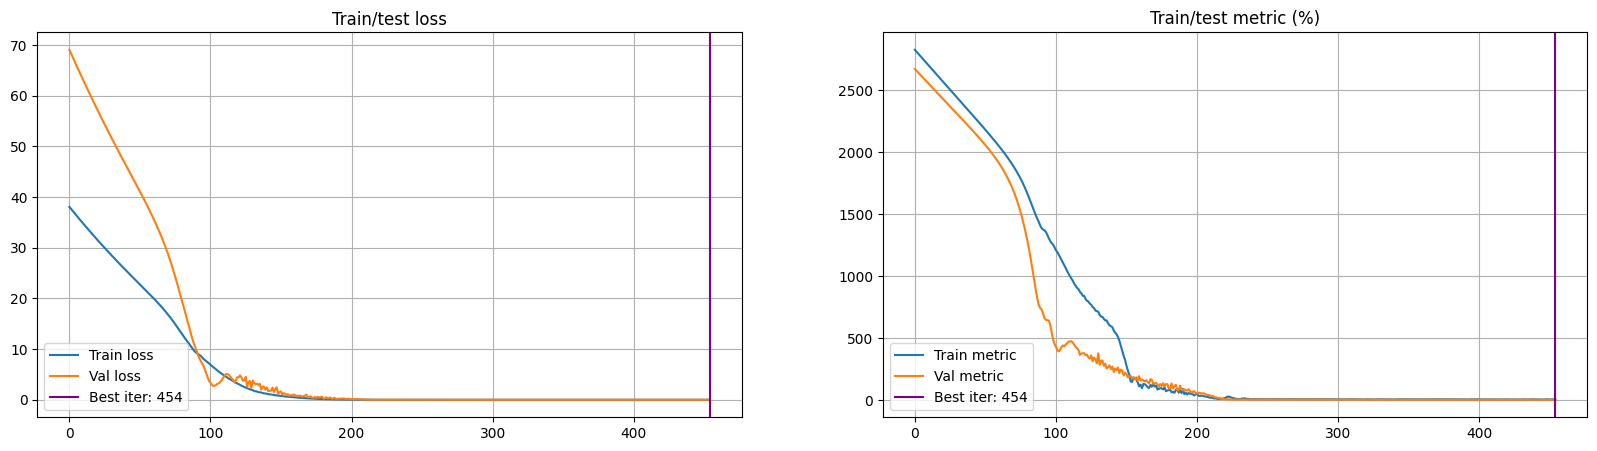

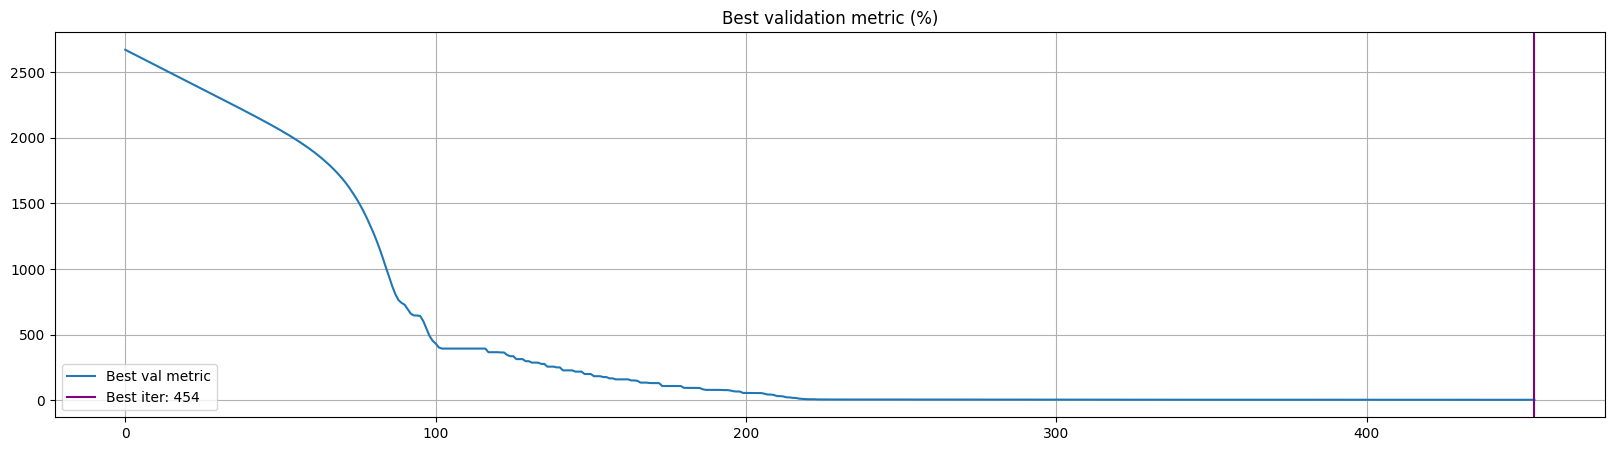

In [27]:
Train_Eval_Plot.plot_train_res(train_res)

In [28]:
model.load_state_dict(train_res["best model"])

<All keys matched successfully>

In [29]:
eval_res = Train_Eval_Plot.eval(model, test_loader, metrics_dict[metric_name], criterion, device= "cpu")

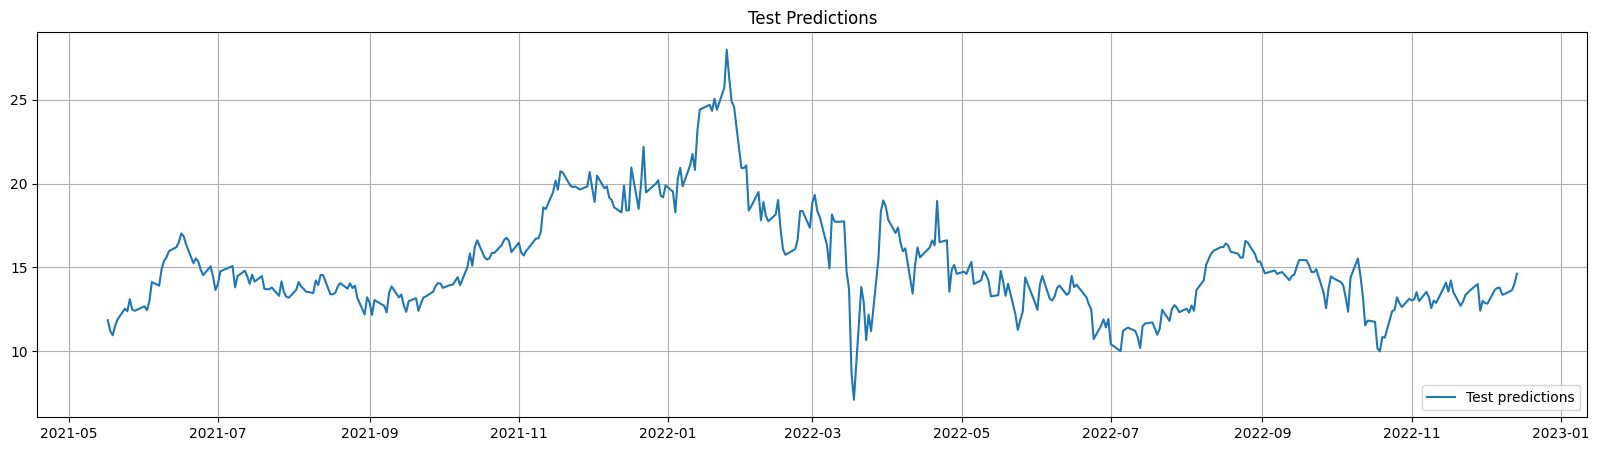

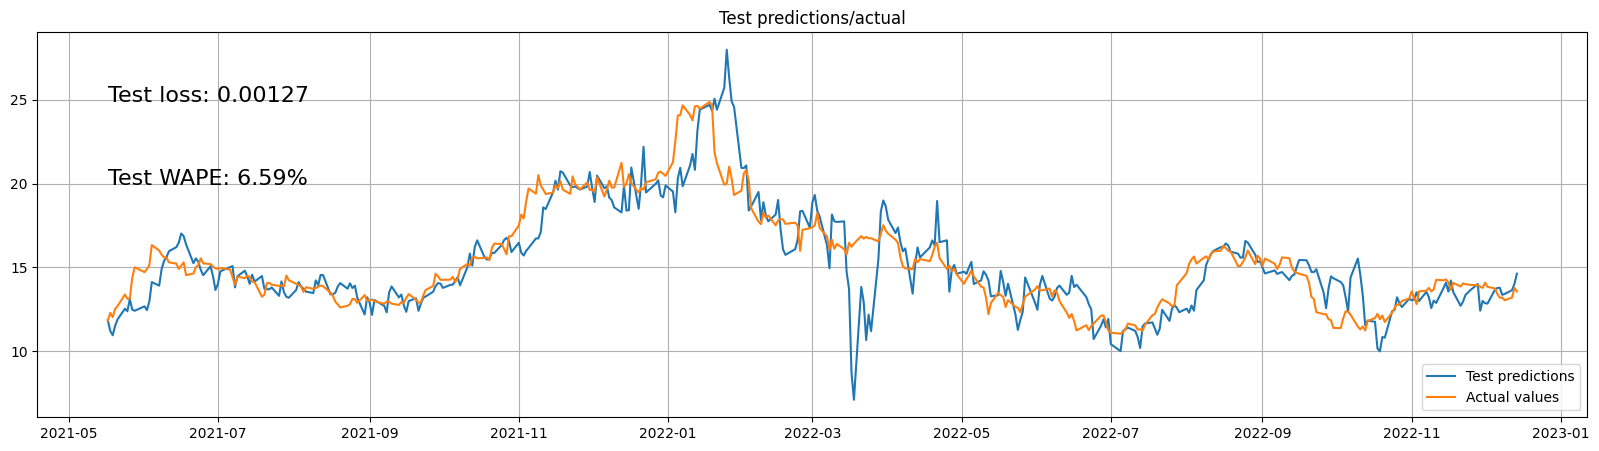

In [30]:
Train_Eval_Plot.plot_eval_res(eval_res, y_test_scaled, scaler, dates_test_y, start= -400, end= None)

In [31]:
model.activation_function.scale_size_2

Parameter containing:
tensor([1.2285], requires_grad=True)

In [32]:
model.activation_function.scale_size

Parameter containing:
tensor([5.3163], requires_grad=True)

# Вычисление доходностей

In [34]:
predicted_open_prices = pd.DataFrame({
    "Test predictions": scaler.inverse_transform(eval_res["test preds"]).reshape(-1),
    "Test ground trouth": y_test.reshape(-1),
}, index= pd.to_datetime(dates_test_y.reshape(-1), dayfirst= True))

predicted_open_prices

,Test predictions,Test ground trouth
2017-11-28,11.477872,12.15
2017-11-29,11.872301,12.24
2017-11-30,12.011890,12.53
2017-12-01,12.355803,12.62
2017-12-04,12.319290,12.65
...,...,...
2022-12-08,13.365976,13.20
2022-12-09,13.415925,13.04
2022-12-12,13.641789,13.20
2022-12-13,14.022017,13.78


In [35]:
pct_change = predicted_open_prices.pct_change()[1:]

predicted_pct_changes = np.array(pct_change["Test predictions"])
test_values = np.array(pct_change["Test ground trouth"])
dates = list(predicted_open_prices.index)[1:]

metric_value = metrics_dict.metrics_dict["RMSE"]()(predicted_pct_changes, test_values)

RMSE: 0.06471220403909683


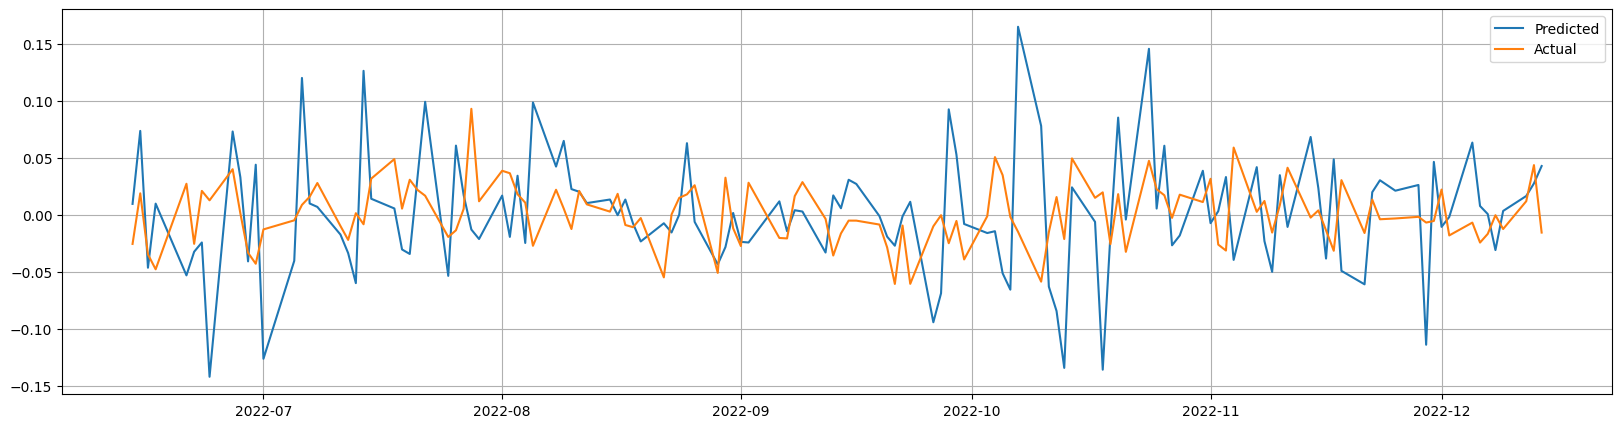

In [36]:
from matplotlib import rcParams

start = -128
end = None

rcParams["figure.figsize"] = 20, 5
print(f"RMSE: {metric_value}")
plt.plot(dates[start:end], predicted_pct_changes[start:end], label= "Predicted")
plt.plot(dates[start:end], test_values[start:end], label= "Actual")
plt.grid(True)
plt.legend(loc= "best")
plt.show()

In [37]:
model.activation_function.scale_size

Parameter containing:
tensor([5.3163], requires_grad=True)